# Simulate gamma ray sources in galaxy

In [9]:
#Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson, laplace, lognorm
from astropy.io import fits
from astropy.table import Table,join
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import catalog_spect
from scipy.optimize import curve_fit
import astropy.coordinates as coord
from astropy import units
import healpy as hp
import makemap
from matplotlib import gridspec

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)
#constants 
kpc = 3.08567758e21 #cm
n = 1000 #Number of spaces in grid (r,z,flux)
model = 'C' #Set model to S or C
if model=='C':
    H=0.18
    alp=1.9
    bet = 5.0
if model=='S':
    H=0.33
    alp=0.2
    bet = 1.4
#From Green 2015
alp_snr = 1.09
bet_snr = 3.98
H_snr = 0.1
Rsun = 8.3
hb = 10 #This is considered as high latitude

#Trheshold of fermi, from 3fgl/3fhl? paper
fermi_thres = 5e-10#min_3fgl_high_lat 
flux_logspace = np.logspace(-12,-6,n)
minflux,maxflux=-13,-5
bins = np.logspace(minflux,maxflux,25)
bins_mean = (bins[1:]+bins[:-1])/2.
lranges = [(-180,180),(-90,90),(-20,20)]
branges = [(-20,20),(-10,10),(-5,5),(-1,1)]

lb = [(180,20),(180,5),(180,1),(20,20),(20,5),(20,1)]

Efhl = np.logspace(1,3,100)#GeV
E3fgl_bins = np.logspace(-1,2,101)
E3fgl = (E3fgl_bins[1:]+E3fgl_bins[0:-1])/2.
E3fgl_dE = (E3fgl_bins[1:]-E3fgl_bins[0:-1])
mask_E3fgl = (E3fgl>=1)&(E3fgl<=100)
Ebins = np.logspace(0,3,101)
E = (Ebins[1:]+Ebins[0:-1])/2.
dE = (Ebins[1:]-Ebins[0:-1])

In [2]:
#Function definitions

def R_dep(R,alpha=alp, beta=bet):
    "R distribution of sources from lorimer"
    return ((R/Rsun)**alpha)*np.exp(-beta*(R-Rsun)/Rsun)

##Drawing random numbers
def rand_R(n,a,b,Rsun=Rsun):
    "Return random value of R, pdf is above, this is a gamma distribution"
    return np.random.gamma(a+1,1./b,n)*Rsun

def rand_z(n,H=H):
    """Return random z from laplace distribution=exp(-abs(z))
    n = number of randoms"""
    return np.random.laplace(0,H,n)

def rand_L(u,a,Lmin,Lmax):
    if a==1:
        print "a==1, error"
        return 0
    return (u*(Lmax**(1-a)-Lmin**(1-a))+Lmin**(1-a))**(1/(1-a))
def convertlb_px(l,b):
    lpix = 2*l+360
    bpix = -2*b+40
    return int(lpix),int(bpix)

In [146]:
#Load 3fgl
file_3fgl = 'gll_psc_v16.fit'
file_3fhl ='gll_psch_v13.fit'
Efhl = np.logspace(1,3,100)#GeV
E3fgl_bins = np.logspace(-1,2,101)
E3fgl = (E3fgl_bins[1:]+E3fgl_bins[0:-1])/2.
E3fgl_dE = (E3fgl_bins[1:]-E3fgl_bins[0:-1])
mask_E3fgl = (E3fgl>=1)&(E3fgl<=100)
Ebins = np.logspace(0,3,101)
E = (Ebins[1:]+Ebins[0:-1])/2.
dE = (Ebins[1:]-Ebins[0:-1])
fhl_fgl = np.zeros_like(E)
mask_E3fhl = E>100
mask_E = (E>=1)&(E<=100)
try:
    fgl=True
    data = fits.getdata(file_3fgl)
except:
    fgl = False
    print "3fgl data not available"
try:
    fhl=True
    data_fhl = fits.getdata(file_3fhl)
except:
    fhl=False
    print "3fhl data not available"
if fgl:
    tb = Table(data)
    cls = np.asarray(tb['CLASS1'].tolist())
    cls = np.char.lower(np.char.rstrip(cls, ' ')) #lower, take SNR and snr
    lat = tb['GLAT']
    lon = tb['GLON']
#Sources to use, use unassosciated sources at low b?
    gal_mask = (cls=='psr') | (cls =='pwn') | (cls=='snr') | (cls=='spp')# | ((cls=='') & (np.abs(lat)<10))
    gal = tb[gal_mask]
    snr_mask = (cls=='snr')|(cls=='pwn')|(cls=='spp')
    psr_mask = cls=='psr'
#    pwn_mask = cls=='pwn'
#    spp_mask = cls=='spp'
    snr = tb[snr_mask]
    tev =snr['ASSOC_TEV']
    snr_tev = snr[np.char.rstrip(tev, ' ')!='']
    snr_ind = snr['Spectral_Index']
    print np.mean(snr_ind)
    psr = tb[psr_mask]
    lat_gal = gal['GLAT'] #l,b of gal sources
    lon_gal = gal['GLON']
    lon_gal[lon_gal>180]-=360
    flux_3fgl = gal['Flux1000']
    lat_snr = snr['GLAT']
    lon_snr = snr['GLON']
    lat_psr = psr['GLAT']
    lon_psr = psr['GLON']
    flux_3fgl_snr = tb[snr_mask]['Flux1000'] 
    flux_3fgl_psr = tb[psr_mask]['Flux1000']
    
    total_flux_3fgl_snr = np.sum(flux_3fgl_snr)
    total_flux_3fgl_psr = np.sum(flux_3fgl_psr)
    
    #spectra
    E3fgl_bins = np.logspace(-1,2,101)
    E3fgl = (E3fgl_bins[1:]+E3fgl_bins[0:-1])/2.
    E3fgl_dE = (E3fgl_bins[1:]-E3fgl_bins[0:-1])
    spec_3fgl = catalog_spect.get_spec(file_3fgl)
    max_spec_3fgl = np.amax(spec_3fgl,axis=1)
    spec_3fgl = spec_3fgl/max_spec_3fgl[:,None] #Normalize to get average spectrum not depended on total flux
    spec_3fgl_gal = spec_3fgl[gal_mask]
    
    ##Split into source classes    
    #spsnr = spec_3fgl[snr_mask]
    #for sp in spsnr:
    #    plt.loglog(E3fgl,E3fgl**2*sp,color='gray')
  #  #Take the mean spectra of log of spectra 3fgl
    def mean_log(spec):
        meanlog = np.mean(np.log10(spec),axis=0)
        return 10**meanlog
        
    ####
    ### This here really matters, whether to take mean or logmean of spectra, check with indices
    spec_3fgl_snr = mean_log(spec_3fgl[snr_mask])
    spec_3fgl_snr = np.mean(spec_3fgl[snr_mask],axis=0)
   # plt.loglog(E3fgl,E3fgl**2*spec_3fgl_snr,color='red',linewidth=3)
   # plt.loglog(E3fgl,E3fgl**2*spec_3fgl_snr2,color='blue',linewidth=3)
    spec_3fgl_psr = mean_log(spec_3fgl[psr_mask])
    plotfunc = lambda E,a,b: b*(E)**-a
    fitfunc = lambda E,a,b: b-a*(E)
    fit,cov = curve_fit(fitfunc,np.log10(E3fgl),np.log10(spec_3fgl_snr))
    spec_3fgl_snr = plotfunc(E,np.mean(snr_ind),10**fit[1])
   # spec_3fgl_snr = plotfunc(E,2.2,10**fit[1])
   # plt.loglog(E3fgl,E3fgl**2*plotfunc(E3fgl,np.mean(snr_ind),10**fit[1]),linewidth=3,color='orange')
    high_lat_mask_3fgl = np.abs(lat_gal)>=hb
    hb_mask_3fgl_snr = np.abs(lat_snr)>=hb
    hb_mask_3fgl_psr = np.abs(lat_psr)>=hb

if fhl:
    tb_fhl= Table(data_fhl)
    cls_fhl = np.asarray(tb_fhl['CLASS'].tolist())
    cls_fhl = np.char.lower(np.char.rstrip(cls_fhl, ' '))
    lat_fhl = tb_fhl['GLAT']
    lon_fhl = tb_fhl['GLON']
#Sources to use, use unassosciated sources at low b?
    gal_mask_fhl = (cls_fhl=='psr') | (cls_fhl =='pwn') | (cls_fhl=='snr') | (cls_fhl=='spp')# | ((cls_fhl=='') & (np.abs(lat_fhl)<10))
    gal_fhl = tb_fhl[gal_mask_fhl]

    
    snr_mask = (cls_fhl=='snr')|(cls_fhl=='pwn')|(cls_fhl=='spp')
    psr_mask = cls_fhl=='psr'
   # pwn_mask = cls_fhl=='pwn'
   # spp_mask = cls_fhl=='spp'
    
    lat_gal_fhl = gal_fhl['GLAT'] #l,b of gal sources
    lon_gal_fhl = gal_fhl['GLON']
    lon_gal_fhl[lon_gal_fhl>180]-=360

    E3fhl = np.logspace(1,3,100)#GeV
    spec_3fhl = catalog_spect.get_spec(file_3fhl)
    max_spec_3fhl = np.amax(spec_3fhl,axis=1)
    max_spec_3fhl = spec_3fhl[:,np.argmin(E<30)]
    spec_3fhl = spec_3fhl/max_spec_3fhl[:,None] #Normalize to get average spectrum not depended on total flux
    spec_3fhl_gal = spec_3fhl[gal_mask_fhl]
    #spsr = spec_3fhl[snr_mask]
    #for sp in spsr:
    #    plt.loglog(Efhl,sp,color='gray')
    
    spec_3fhl_snr =mean_log(spec_3fhl[snr_mask])
    spec_3fhl_psr = mean_log(spec_3fhl[psr_mask])
    #plt.loglog(Efhl,spec_3fhl_snr,color='red',linewidth='5')

#####   
#Interpolate spec from 1-1000 GeV
#####
def norm_spec(spec,flux,dE,mask):
    """This function normalizes the spec(actually wrong_spec below) 
    to the integrated flux from 1-100GeV
    """
    wrong_spec = spec*flux
    norm = np.sum(wrong_spec[mask]*dE[mask])
    return wrong_spec*flux/norm


good_spec_3fgl_snr = norm_spec(spec_3fgl_snr,total_flux_3fgl_snr,E3fgl_dE,mask_E3fgl)
good_spec_3fgl_psr = norm_spec(spec_3fgl_psr,total_flux_3fgl_psr,E3fgl_dE,mask_E3fgl)
###If use not fitted spectrum change this
#intp_3fgl_snr = np.interp(E,E3fgl,good_spec_3fgl_snr)#good_spec_3fgl_snr #
intp_3fgl_snr = good_spec_3fgl_snr #
intp_3fgl_psr = np.interp(E,E3fgl,good_spec_3fgl_psr)
norm_snr = intp_3fgl_snr[np.argmin(E<100)]
norm_psr = intp_3fgl_psr[np.argmin(E<100)]
intp_3fhl_snr = np.interp(E,Efhl, spec_3fhl_snr*norm_snr)
intp_3fhl_psr = np.interp(E,Efhl, spec_3fhl_psr*norm_psr)
##and change this
#intp_3fgl_snr[mask_E3fhl] = intp_3fhl_snr[mask_E3fhl]
intp_3fgl_psr[mask_E3fhl] = intp_3fhl_psr[mask_E3fhl]

#Normalize flux to be between 0-1, so as to multiply with flux at 1 GeV and get desired spectrum
intp_3fgl_snr_normed = intp_3fgl_snr/np.max(intp_3fgl_snr)
intp_3fgl_psr_normed = intp_3fgl_psr/np.max(intp_3fgl_psr)

#plt.loglog(E,intp_3fgl_snr_normed)

#log n log s

#    N_3fgl = np.zeros(n)

#Create log n log s plot, deprecated??
  #  for i,f in enumerate(flux_logspace):
  #      N_3fgl[i] = len(spec_3fgl[flux_3fgl > f])

dist_tb = [3.5,2,2,1.5,0.29,0.2,6.6,5.2,None,6.5,None,8.6,None,1,7.9,11.5,None,8.3,2,6,3.7,3.9,4,6.6,None,4.3,None,0.8,3.4]
dist_tb = np.array(dist_tb)
mask_dist = dist_tb!=None
L_tev = snr_tev['Flux1000'][mask_dist]*(4*np.pi*(dist_tb[mask_dist]*kpc)**2).tolist()

2.28822


In [147]:
###Load diffuse flux from skyfact fit

import open_dat

def read_datfile(datFile):
    "Read dat file and return total gas spec"
    E_diff = datFile['emean']
    deltaE = datFile['delta_e']
    total_gas_spec = np.zeros_like(E_diff)
    total_gas_err = np.zeros_like(E_diff)
    mask_diff = E_diff > 1
    for d in datFile:
        if 'Gas' in d and not 'err' in d:
            total_gas_spec+=datFile[d]
            total_gas_err +=datFile[d+'_err']
    return total_gas_spec/deltaE,E_diff,total_gas_err/deltaE
    

dict_files = {}
spec_diff_lb = []
diff_index_lb = []
plotfunc = lambda E,a,b: b*(E)**-a
fitfunc = lambda E,a,b: b-a*(E)
for ilb in lb:
    datfile = open_dat.open_dat('spec_ll_bb/r5_fulldisk_combine_l%s_b%s.dat'%ilb)
    spec,E_diff,error = read_datfile(datfile)
    mask_E_diff = E_diff > 2
    E_diff = E_diff[mask_E_diff]
    spec = spec[mask_E_diff]
        
    fit,cov = curve_fit(fitfunc,np.log10(E_diff),
                        np.log10(spec),sigma=error[mask_E_diff]/spec)
   # plt.loglog(E_diff,E_diff**2*plotfunc(E_diff,fit[0],10**fit[1]))
   # plt.loglog(E_diff,E_diff**2*spec,
   #                       marker='.',linestyle='',label=ilb)
    fitted_spec = plotfunc(E,fit[0],10**fit[1]) ##If this is a softer spectra this matters a lot!
    spec_diff_lb.append(fitted_spec)
   # print fit[0]
       # plt.loglog(E,E**2*fitted_spec)
        #plt.legend()
        
#E_diff = E_diff[mask_diff]

#    fit,cov = curve_fit(fitfunc,np.log10(E_diff),np.log10(total_gas_spec),sigma=total_gas_err/total_gas_spec)
#    diff_index = fit[0]

In [148]:
#Do the simulation monte carlo
def mc_smpl(a=2,N=1000,Lmin=3e34,Lmax=1e40,alpha=alp,beta=bet,H=H,SNR=False,PSR=False,fermi_thres=5e-10,flux_cutoff=1e-20):
    #np.random.seed(0)
    """Sample from above distribution N times: r,z,L and calculate flux as measured at earth"""
    N = int(N) #no samples just to be sure 

    x0,y0,z0 = Rsun,0,0 #Location of us
    ##
    ##Drawing random numbers here
    u2 = np.random.rand(N)# For L
    phi_smpl = np.random.rand(N)*2*np.pi #uniform distribution for phi
    L_smpl = rand_L(u2,a,Lmin,Lmax)#random L
    z_smpl = rand_z(N,H)
    R_smpl = rand_R(N,alpha,beta)
    
    #distances from source to earth, calc flux
    x,y,z = R_smpl*np.cos(phi_smpl),R_smpl*np.sin(phi_smpl),z_smpl
    dist = np.sqrt(((x-x0))**2+((y-y0))**2+(z-z0)**2)
    distkpc = (dist*kpc)
    flux_data = L_smpl/(4*np.pi*distkpc**2)

    l = np.arctan2((y0-y),(x0-x))
    b = np.arctan((z-z0)/np.sqrt((x-x0)**2+(y-y0)**2))
    l *= 180/np.pi
    b *= 180/np.pi

    ##My function, that does conserve flux, but does it always work?
    #mp = makemap.makemap(l,b,flux_data,0.5)
        
    high_lat_mask = np.abs(b)>hb
    flux_hb = flux_data[high_lat_mask] 
    #histogram for normalization
    
    hist = np.histogram(flux_data,bins=bins)[0]
    #Fluxes at different regions

    dict_flux_lb = {}
    dict_flux_lb['lb']=[]
    dict_flux_lb['flux100']=[]
    frac = []
    for ilb,_lb in enumerate(lb):
        ll,bb = _lb
        mask_l = np.abs(l)<=ll
        mask_b = np.abs(b)<=bb
        total_flux_lb = flux_data[mask_l&mask_b]
        flux_unresolved = total_flux_lb[total_flux_lb<fermi_thres]
        flux_unresolved[flux_unresolved<flux_cutoff]=0
        total_flux_unres = np.sum(flux_unresolved)
        dict_flux_lb['lb'].append((ll,bb))
        dict_flux_lb['flux100'].append(total_flux_unres)
        if SNR:
            spec_sim = norm_spec(intp_3fgl_snr_normed,total_flux_unres,dE,mask_E)
        elif PSR:
            spec_sim = norm_spec(intp_3fgl_psr_normed,total_flux_unres,dE,mask_E)
        else:
            print "no spec output"
            spec_sim = 0
        diffuse = spec_diff_lb[ilb]
        frac.append(spec_sim/diffuse)

    
    return hist,dict_flux_lb,frac

In [149]:
#Runs simulation Nsmpl times with N=n.o. sources, normalize to 3fgl sources

#Nsnr = 150000
#Npsr = 20000
#Nsmpl = 10

def ave_samples(Nsmpl=10,Nsnr=100000,Npsr=20000,LF_i_snr=1.8,LF_i_psr=1.7,
                Lmin_snr=1e33,Lmax_snr=4e38,Lmin_psr=1e34,Lmax_psr=1e40,
                fermi_thres=5e-10,flux_cutoff = 1e-12,plothist=False,printstatements=False):

    print "Doing %s sample galaxys with %s SNR's and %s PSR's, this might take some time..."%(Nsmpl,Nsnr,Npsr)
    fluxes_snr = []
    fluxes_psr = []
    hist_snr = np.zeros((Nsmpl,len(bins_mean)))
    hist_psr = np.zeros((Nsmpl,len(bins_mean)))
    frac_snr = []
    frac_psr = []
    for i in range(Nsmpl):
        if i%(Nsmpl/10.)==0 and printstatements:
            print 100*i/float(Nsmpl),"% done"
        #fluxes_snr[i,:]=(mc_smpl(1.9,Nsnr,1e33,5e38,alp_snr,bet_snr)[0])
        #fluxes_psr[i,:]=(mc_smpl(1.7,Npsr,1e34,1e40,alp,bet)[0])
        hist_snr[i,:],dict_snr,ifrac_snr = mc_smpl(LF_i_snr,Nsnr,Lmin_snr,Lmax_snr,alp_snr,bet_snr,H_snr,SNR=True,flux_cutoff=flux_cutoff)
        hist_psr[i,:],dict_psr,ifrac_psr = mc_smpl(LF_i_psr,Npsr,Lmin_psr,Lmax_psr,alp,bet,PSR=True,flux_cutoff=flux_cutoff)
        fluxes_snr.append(dict_snr['flux100'])
        fluxes_psr.append(dict_psr['flux100'])
        frac_snr.append(ifrac_snr)
        frac_psr.append(ifrac_psr)

    ave_frac_snr = np.average(frac_snr,axis=0) #For a roi a fraction for every E bin
    ave_frac_psr = np.average(frac_psr,axis=0)
    
    ave_flux_snr = np.average(fluxes_snr,axis=0)
    ave_flux_psr = np.average(fluxes_psr,axis=0)
    
    if plothist:
                ###################
        #Histogram of flux vs N

        f1,ax1 = plt.subplots(1,figsize=(12,8))
        ax1.loglog(bins_mean,np.rint(np.mean(hist_snr,axis=0)),marker='^',label='sim snr', color='green')
        ax1.loglog(bins_mean,np.rint(np.mean(hist_psr,axis=0)),marker='v',label='sim psr', color='peru')


        hist_3fgl_snr = np.histogram(flux_3fgl_snr,bins=bins)[0]
        hist_3fgl_psr = np.histogram(flux_3fgl_psr,bins=bins)[0]
        ax1.loglog(bins_mean,hist_3fgl_snr,marker='^', color='orange', label='3fgl SNR')
        ax1.loglog(bins_mean,hist_3fgl_psr,marker='v', color='purple', label='3fgl PSR') 

        ax1.set_xlabel(r'flux ph $cm^{-2} s^{-1}$')
        ax1.set_ylabel('Source counts')
        ax1.legend(prop={'size':20})
        
    return ave_frac_snr,ave_frac_psr

iE100 = np.argmax(E>100)
options_labels = [('Nsnr','LF_i_snr','Lmin_snr','Lmax_snr','flux_cutoff','fermi_thres')]
options = [(10000,1.5,1e33,5e38),(150000,2.1,1e34,1e39),(100000,1.9,5e33,1e39),(50000,1.8,5e33,5e38)]
snr_frac = []
for op in options:
    N,LF_i,Lmin,Lmax = op
    ave_frac_snr,ave_frac_psr = ave_samples(10,Nsnr=N,LF_i_snr=LF_i,Lmin_snr=Lmin,Lmax_snr=Lmax)#,plothist=True,printstatements=True)
    snr_frac.append(ave_frac_snr)
#print snr_frac
print "done..."

Doing 10 sample galaxys with 10000 SNR's and 20000 PSR's, this might take some time...
Doing 10 sample galaxys with 150000 SNR's and 20000 PSR's, this might take some time...
Doing 10 sample galaxys with 100000 SNR's and 20000 PSR's, this might take some time...
Doing 10 sample galaxys with 50000 SNR's and 20000 PSR's, this might take some time...
done...


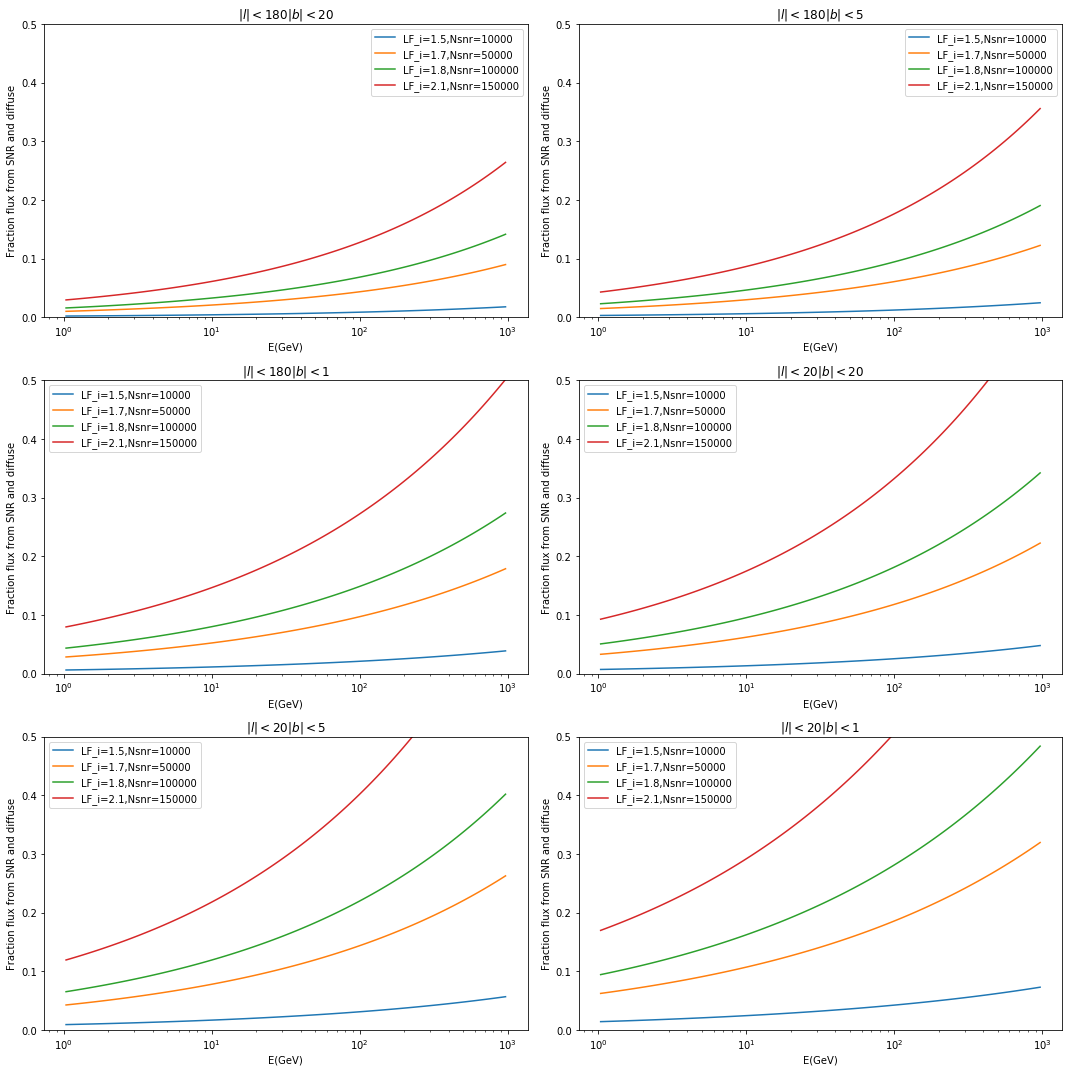

In [150]:
#Take the average spectra of 3fgl+3fhl and give that spectra to the simulated sources
#Plot the spectra from 1-1000GeV
snr_frac = np.array(snr_frac)


#fig = plt.figure(figsize=(15,15))
fig2 = plt.figure(figsize=(15,15))
#gs = gridspec.GridSpec(3,2)
gs2 = gridspec.GridSpec(3,2)

for di in range(len(spec_diff_lb)):

    _l,_b = lb[di]
    #diffuse = spec_diff_lb[di]

    
   # gsi = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs[di])
   # ax = plt.Subplot(fig,gs[di])
   # ax.loglog(E,E**2*diffuse,label='diffuse')
   # ax.loglog(E,E**2*spec_sim_psr, label='psr')
   # ax.loglog(E,E**2*spec_sim_snr,label='snr')
   # ax.set_title(r'$|l| < %s |b| < %s$'%(_l,_b))
   # ax.set_ylim([1e-9,1e-4])
   # ax.set_xlabel("E(GeV)")
   # ax.set_ylabel(r"$E^2 \ dN/dE \ [GeV \ cm^{-2} \ s^{-1}]$") 
   # fig.add_subplot(ax)
   # ax.tick_params(axis='both', which='major', labelsize=6, pad=2)
   # ax.tick_params(axis='both', which='minor', labelsize=6, pad=2)
  
    div = snr_frac[0,di]
    div2 = snr_frac[3,di]
    div3 = snr_frac[2,di]
    div4 = snr_frac[1,di]
    gsi2 = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs2[di])
    ax2 = plt.Subplot(fig2,gs2[di])
    ax2.semilogx(E,div,label='LF_i=1.5,Nsnr=10000')
    ax2.semilogx(E,div2,label='LF_i=1.7,Nsnr=50000')
    ax2.semilogx(E,div3,label='LF_i=1.8,Nsnr=100000')
    ax2.semilogx(E,div4,label='LF_i=2.1,Nsnr=150000')
    ax2.set_ylim([0,0.5])
    ax2.set_title(r'$|l| < %s |b| < %s$'%(_l,_b))
    ax2.set_xlabel('E(GeV)')
    ax2.set_ylabel('Fraction flux from SNR and diffuse')
    fig2.add_subplot(ax2)
    plt.legend()
    #ax2.tick_params(axis='both', which='major', labelsize=6, pad=2)
    #ax2.tick_params(axis='both', which='minor', labelsize=6, pad=2)
    
plt.tight_layout()
plt.savefig('fraction_ps_diffuse.pdf')